# Session 2 - Interest Rate Risk

## Fixed Income Seminar

### FINM 37200
### Spring 2022

#### Mark Hendricks
#### hendricks@uchicago.edu

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *

# Dynamics Over Time

## Prices of a bond

We have discussed the **spot curve** (also known as the yield curve, or term structure of interest rates.)

This curve is determined on a single date, looking across a range of bond issues.

#### Consider the alternate, looking at a range of dates for a single bond issue.

The figure below shows the price history for a 10-year note.

In [2]:
filepath_tsdata = f'../data/treasury_ts_2022-02-15.xlsx'
tsdata = pd.read_excel(filepath_tsdata,sheet_name='ts')
tsdata.columns = tsdata.columns.str.upper()

In [3]:
filepath = '../data/yields.xlsx'
yields = pd.read_excel(filepath, sheet_name='yields')
yields.set_index('caldt',inplace=True)

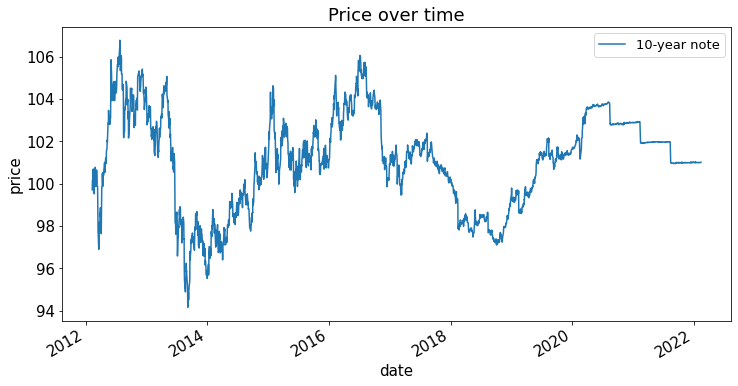

In [4]:
ask = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDASK')
price = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDASK') + tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDACCINT')
ret = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDRETNUA')

treasnos = ask.columns
ask.columns = ['10-year note','3-year note','4-month bill']
ret.columns = ['10-year note','3-year note','4-month bill']
price.columns = ['10-year note','3-year note','4-month bill']

price['10-year note'].plot(xlabel='date',ylabel='price',title='Price over time')
plt.legend()
plt.show()

Note that
* the price varies substantially
* there are periods where price is greater than 100 (above par) due to the coupon
* the price since the pandemic has moved nearly in lockstep with coupon payments

Recall that this is the **dirty price** which includes accrued interest of the coupons.

Compare the quoted, **clean ask price** with this dirty price.

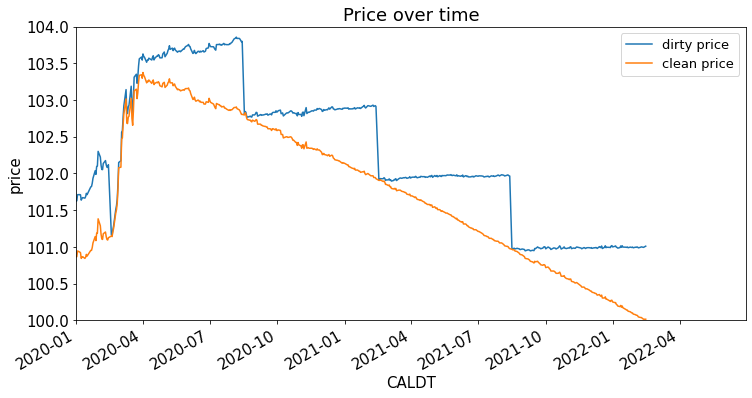

In [5]:
ax = price['10-year note'].plot(xlabel='date',ylabel='price',title='Price over time',xlim=('2020-01-01','2022-06-30'),ylim=(100,104))
ask['10-year note'].plot(ax=plt.gca())
plt.legend(['dirty price','clean price'])
plt.show()

### Returns
Below, plot the cumulative return of the bond, including coupons.

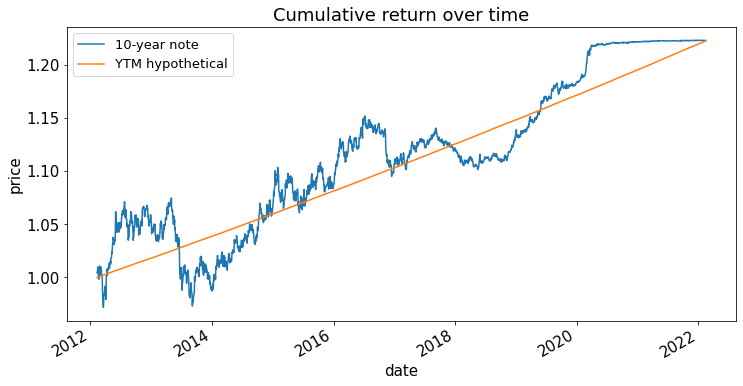

In [6]:
rets_comparison = pd.concat([ret['10-year note'],price['10-year note'].pct_change(),ask['10-year note'].pct_change()],axis=1).corr()

yld_initial = tsdata[tsdata['KYTREASNO']==treasnos[0]].sort_values('CALDT')['TDYLD'].iloc[0] * (365.25/252)
ret_hypothetical = pd.DataFrame(index=ret.index,columns=['YTM hypothetical'])
for i,dt in enumerate(ret_hypothetical.index):
    ret_hypothetical.loc[dt,'YTM hypothetical'] = (1+yld_initial)**i

(ret['10-year note']+1).cumprod().plot(xlabel='date',ylabel='price',title='Cumulative return over time')
ret_hypothetical.plot(ax=plt.gca(),xlabel='date')
plt.legend()
plt.show()

Note that the cumulative return is...
* not proportional to the price, due to the coupons
* risky!
* well above/below what the YTM at issue would imply

The YTM is the **annualized average return**

Furthermore, note that the price and return graphs above show little variation since 2020. This is not an error, but rather reflects the near-0 volatility of interest rates in that time period.

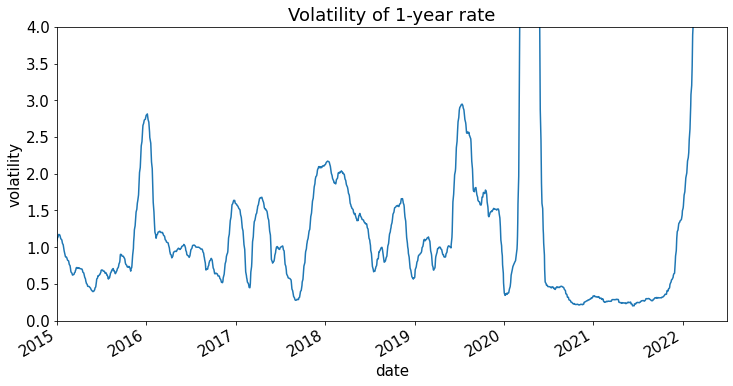

In [7]:
yield_vol = yields[1].rolling(21*3).std()*np.sqrt(252)
yield_vol.plot(xlim=('2015-01-01','2022-06-30'),ylim=(0,4),xlabel='date',ylabel='volatility',title='Volatility of 1-year rate')
plt.show()

### Bills

Consider the price and return of a 4-month T-bill
* interest rates were low and nearly constant during this time.
* market liquidity and frictions cause the price to go over 100

Note that the cumulative return is proportional to the price, (since there are no coupons.)

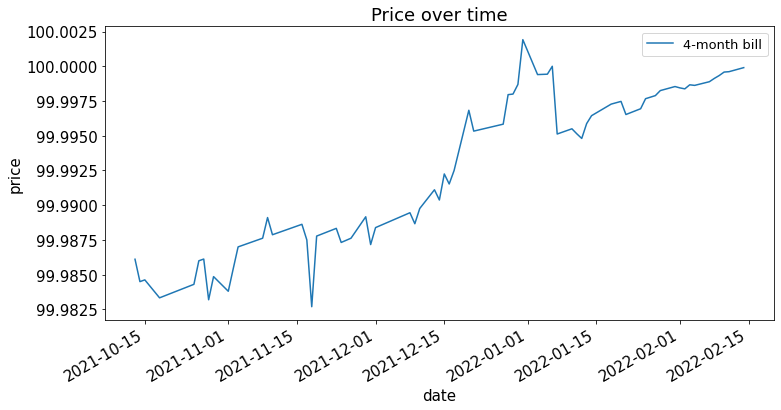

In [8]:
ask['4-month bill'].plot(ylabel='price',title='Price over time',xlabel='date')
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%3.4f'))
plt.legend()
plt.show()

## TIPS vs Nominal

Consider the movement of TIPS versus nominal notes.

Below shows two 30-year bonds, a TIPS and a nominal, each maturing `2041-02-15`. 

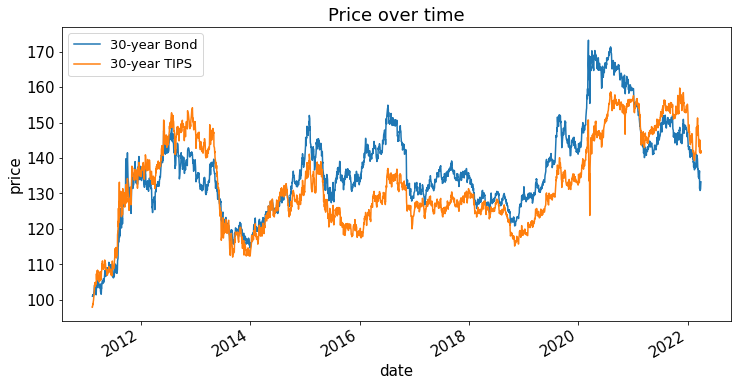

In [9]:
filepath_tsdata = f'../data/treasury_ts_2041-02-15_tips.xlsx'
tsdata = pd.read_excel(filepath_tsdata,sheet_name='ts')
tsdata.columns = tsdata.columns.str.upper()
ask = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDASK')
ret = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDRETNUA')

ask.columns = ['30-year Bond','30-year TIPS','2-year Note']
ret.columns = ['30-year Bond','2-year Note']

ask[['30-year Bond','30-year TIPS']].plot(ylabel='price',title='Price over time',xlabel='date')
plt.legend()
plt.show()

In [10]:
display(f'Correlation between TIPS and nominal prices over full history: {ask.pct_change().corr().values[0,1]:.2%}')
display(f'Correlation between TIPS and nominal prices over past 3 months: {ask.iloc[-63:,[0,1]].pct_change().corr().values[0,1]:.2%}')

'Correlation between TIPS and nominal prices over full history: 84.11%'

'Correlation between TIPS and nominal prices over past 3 months: 63.90%'

#### Consider the total return since the last coupon date.

<AxesSubplot:title={'center':'Cumulative return'}, xlabel='date', ylabel='price'>

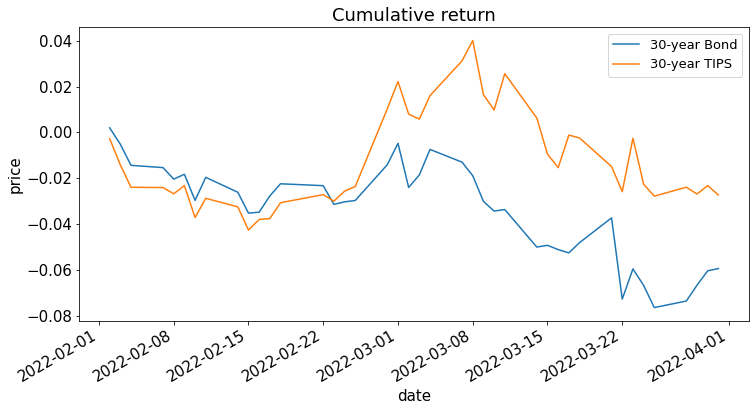

In [11]:
temp = (1+ask.iloc[-42:,[0,1]].pct_change()).cumprod()-1
temp.plot(xlabel='date',ylabel='price',title='Cumulative return')

## Yield Curve Over Time

Of course, changing prices and rates imply the entire yield curve is changing over time.

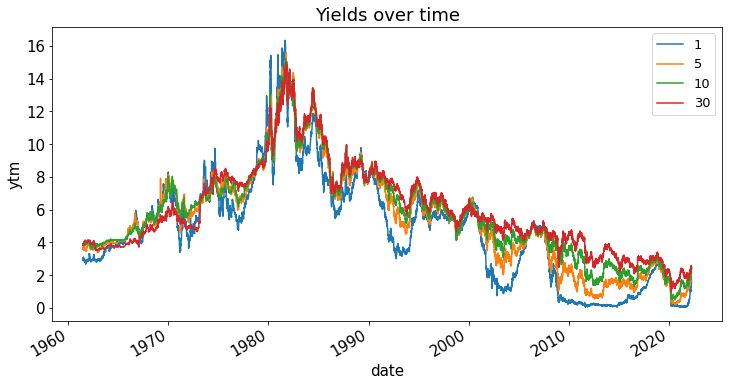

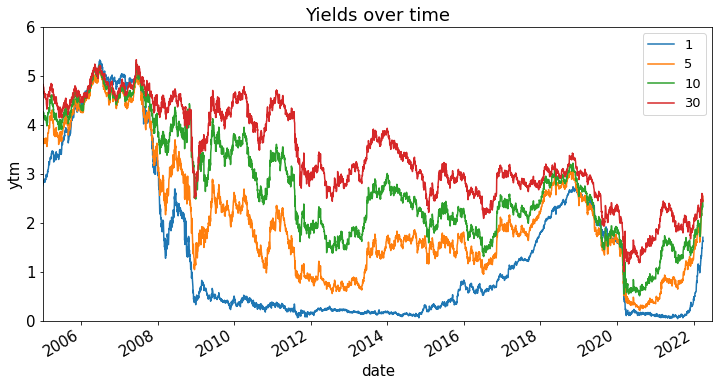

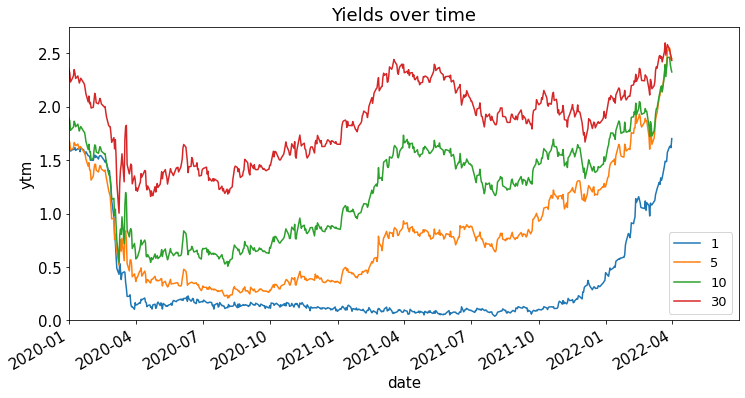

In [12]:
yields[[1,5,10,30]].plot(title='Yields over time',xlabel='date',ylabel='ytm')
yields[[1,5,10,30]].plot(xlim=('2005-01-01','2022-06-30'),ylim=(0,6),title='Yields over time',xlabel='date',ylabel='ytm')
yields[[1,5,10,30]].plot(xlim=('2020-01-01','2022-06-30'),ylim=(0,2.75),title='Yields over time',xlabel='date',ylabel='ytm')
plt.show()

# Measuring Sensitivity

Clearly, 
* interest rates move substantially
* this impacts prices 

For fixed income securities, it is important to measure the sensitivity of prices to rates.

Why not estimate this relationship statistically with linear regression? There are **two challenges**:

1. Which interest rate should we analyze?
1. Over the time-series, maturity is changing, making it an inconsistent sample

### Many rates

Fixed income prices depend on (potentially) the entire term structure of rates. 

Thus, we could check sensitivity to...
* the 1-month, 3-month, 1-year, 5-year, 10-year, etc.
* some combination of these rates

### Changing target

Typically, we would estimate a statistical sensitivity using a time-series of data.
* But over time, a bond's maturity changes.
* Thus, we do not have a coherent estimate, as the sensitivity of a 5-year bond may be different than the sensitivity of a 4-year bond.

Note that we do not have this problem as obviously for an equity target. 
* Over a year, a share of Apple does not become a share of GM
* Unless Apple's operation changes enormously, we expect stability in medium-range timeseries.

For bonds, we can not count on this.


### Using math, not just statistical estimation

Fortunately, bonds have a clear mathematical relationship to a certain rate movement.

Thus, we can bypass these two challenges to calculate bond sensitivity.

## Duration

**Duration** refers to the sensitivity of a bond (or other fixed-income product) to the **level of interest rates**.

Rather than measure sensitivity to the 3-month, 1-year, or 10-year rate, measure sensitivity to a parallel shift in all these rates, all else equal.

$$\begin{align}
D \equiv -\frac{1}{P}\frac{dP}{dr}
\end{align}$$

Note the following
* Dduration is a **percentage** change in the price, (via the $1/P$ term).
* We denote the parallel shift in the spot curve with $dr$
* The negative in the definition is so that the resulting duration will be a positive number. ($dP/dr$ is a negative number!)

### Price approximation

If we know the duration of a fixed income asset, then we can approximate the percentage price change in response to a shift in rates. The approximation is

$\begin{align}
\frac{dP}{P} \approx -D\times dr
\end{align}$


### Duration of a zero-coupon bond

For a **zero coupon bond** this derivative has a simple solution:
$$\begin{align}
D_{\text{zero}} \equiv -\frac{1}{P(t,T,0)}\frac{dP(t,T,0)}{dr} = T-t
\end{align}$$

#### For zero-coupon treasuries, duration is equal to the maturity 

The chart below shows CRSP's imputed duration for each bond issue.

In [13]:
QUOTE_DATE = '2021-12-31'
filepath_rawdata = f'../data/treasury_quotes_{QUOTE_DATE}.xlsx'
rawdata = pd.read_excel(filepath_rawdata,sheet_name='quotes')
rawdata.columns = rawdata.columns.str.upper()
rawdata.sort_values('TMATDT',inplace=True)
rawdata.set_index('KYTREASNO',inplace=True)

t_check = rawdata['CALDT'].values[0]
if rawdata['CALDT'].eq(t_check).all():
    t_current = t_check
else:
    warnings.warn('Quotes are from multiple dates.')
    t_current = None

rawprices = (rawdata['TDBID'] + rawdata['TDASK'])/2 + rawdata['TDACCINT']
rawprices.name = 'price'

maturity_delta = get_maturity_delta(rawdata['TMATDT'],t_current)
maturity_delta.name = 'maturity delta'

metrics = rawdata.copy()[['TDATDT','TMATDT','TDPUBOUT','TCOUPRT','TDYLD','TDDURATN']]
metrics.columns = ['issue date','maturity date','outstanding','coupon rate','yld','duration']
metrics['yld'] *= 365
metrics['duration'] /= 365
metrics['outstanding'] *= 1e6
metrics['maturity interval'] = get_maturity_delta(metrics['maturity date'], t_current)
metrics['price'] = rawprices

display(f'Treasuries quoted on {QUOTE_DATE}.')

'Treasuries quoted on 2021-12-31.'

Compare `duration` to `maturity interval`.

As derived, the duration exactly equals the maturity.

In [14]:
display(metrics[metrics['coupon rate']==0].head(5))
display(metrics[metrics['coupon rate']==0].tail(5))

,issue date,maturity date,outstanding,coupon rate,yld,duration,maturity interval,price
KYTREASNO,,,,,,,,
207764,2021-09-07,2022-01-04,NaN,0.0,-0.000304,0.010959,0.010951,100.000333
207737,2021-07-08,2022-01-06,NaN,0.0,0.000051,0.016438,0.016427,99.999917
207765,2021-09-14,2022-01-11,NaN,0.0,0.000025,0.030137,0.030116,99.999924
207738,2021-07-15,2022-01-13,NaN,0.0,0.000507,0.035616,0.035592,99.998194
207766,2021-09-21,2022-01-18,NaN,0.0,-0.000152,0.049315,0.049281,100.000750


,issue date,maturity date,outstanding,coupon rate,yld,duration,maturity interval,price
KYTREASNO,,,,,,,,
207773,2021-09-09,2022-09-08,NaN,0.0,0.002080,0.687671,0.687201,99.857069
207774,2021-10-07,2022-10-06,NaN,0.0,0.002486,0.764384,0.763860,99.810125
207787,2021-11-04,2022-11-03,NaN,0.0,0.002563,0.841096,0.840520,99.784674
207801,2021-12-02,2022-12-01,NaN,0.0,0.002843,0.917808,0.917180,99.739444
207818,2021-12-30,2022-12-29,NaN,0.0,0.003809,0.994521,0.993840,99.621875


### For coupon-paying treasuries, duration is more complex

Note how different the `maturity interval` and `duration` columns are.

In [15]:
display(metrics[(metrics['maturity interval']-metrics['duration'])>7])

,issue date,maturity date,outstanding,coupon rate,yld,duration,maturity interval,price
KYTREASNO,,,,,,,,
207187,2018-02-15,2048-02-15,3.813900e+10,3.000,0.019037,18.980502,26.124572,123.367188
207216,2018-05-15,2048-05-15,4.017400e+10,3.125,0.018966,19.089710,26.370979,125.553349
207248,2018-08-15,2048-08-15,4.479200e+10,3.000,0.019044,19.245368,26.622861,123.679688
207270,2018-11-15,2048-11-15,4.499100e+10,3.375,0.018850,19.088555,26.874743,131.475742
207314,2019-02-15,2049-02-15,4.745900e+10,3.000,0.018950,19.518588,27.126626,124.226562
207363,2019-05-15,2049-05-15,4.629200e+10,2.875,0.018944,19.921768,27.370294,120.990331
207719,2021-05-15,2051-05-15,7.493600e+10,2.375,0.018931,21.722308,29.368925,110.879921
207763,2021-08-15,2051-08-15,7.455900e+10,2.000,0.018991,22.427786,29.620808,102.796875


### Duration of a coupon bond

Duration, (as a derivative,) is a **linear operator**. Accordingly,
* the duration of a portfolio is the weighted average of the duration of the components
* a coupon bond is simply a portfolio of zero coupon bonds

Thus,
$$\begin{align}
D_{\text{portfolio}} = & \sum_{i=1}^n w_iD_i
\end{align}$$
where $D_i()$ denotes the duration of portfolio security $i$, and where $w_i$ denotes the weight (as a fraction) of security $i$ in the portfolio.

Thus, define the weights of the payments of a coupon bond as
$$\begin{align}
w_i \equiv & \frac{c}{2}\frac{P(t,T_i,0)}{P(t,T,c)}\text{ for } 1\le i < n\\
\equiv & \left(1+\frac{c}{2}\right)\frac{P(t,T,0)}{P(t,T,c)}\text{ for } i=n
\end{align}$$
Then
$$\begin{align}
D_{\text{coupon bond}} \equiv& \frac{1}{P(t,T,c)}\frac{dP(t,T,c)}{dr}\\
=& \sum_{i=1}^n w_iD_i\\
=& \sum_{i=1}^n w_i T_i
\end{align}$$
where the final equality uses the result that the duration of a zero-coupon bond is simply the maturity.

#### This final equality shows that the duration of the coupon bond is the weighted average of the cashflow maturities.
$$\begin{align}
D_{\text{coupon bond}} =& \sum_{i=1}^n w_i T_i
\end{align}$$

### Duration as time-to-maturity

We see from above that duration for a standard coupon bond is the weighted average of time to cashflow.

* Sometimes this is given as the definition of duration.

* But this result will not hold for other types of fixed=income securities, (including floating rate bonds.) 

* Thus, consider this a result of duration for standard bonds, but retain the definition as the price sensitivity to a parallel shift in the spot curve.

### Coupon rate

A higher coupon rate decreases the duration. 

* The higher the coupon rate, the more cash that is arriving sooner (before maturity). These coupons are not as impacted by changes in the spot rate, as the discounting doesn't compound as long.

* We could also see this as the higher coupon reduces the weighted average of time-to-cash.

# Calculating Duration

## Import a Zero Curve

In [16]:
MODEL = nelson_siegel

RESTRICT_YLD = True
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = False
RESTRICT_REDUNDANT = False

data = filter_treasuries(rawdata, t_date=t_current, filter_yld = RESTRICT_YLD, filter_tips = RESTRICT_TIPS, drop_duplicate_maturities=RESTRICT_REDUNDANT)

CF = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=RESTRICT_DTS_MATURING)

prices = metrics['price'][CF.index]

params = estimate_rate_curve(nelson_siegel,CF,t_current,prices)
if MODEL == nelson_siegel_extended:
    x0 = np.concatenate((params_NS,(1,1)))
    params = estimate_rate_curve(nelson_siegel_extended,CF,t_current,prices,x0=x0)

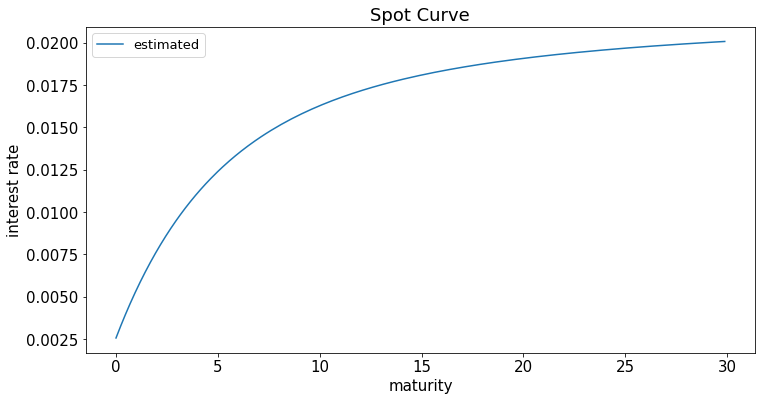

In [17]:
maturity_grid = get_maturity_delta(CF.columns,t_current)
curve = nelson_siegel(params,maturity_grid)

curves = pd.DataFrame(index = maturity_grid)
if MODEL == nelson_siegel_extended:
    curves['estimated']= nelson_siegel_extended(params,maturity_grid)
else:
    curves['estimated'] = nelson_siegel(params,maturity_grid)

curves.plot(xlabel='maturity',ylabel='interest rate',title='Spot Curve')
plt.show()

### Weights of each coupon in the coupon bond "portfolio"

In [18]:
#CF = calc_cashflows(rawdata)

CF_prices = price_with_rate_model(params,CF,t_current,MODEL,price_coupons=True)
model_prices = CF_prices.sum(axis=1)

CF_wts = CF_prices.div(model_prices,axis=0)
display(CF_wts.iloc[-5:,-10:].style.format('{:.2%}'))

CF_intervals = get_maturity_delta(CF.columns.to_series(),t_current)
model_duration = (CF_wts * CF_intervals).sum(axis=1)

,2049-08-15 00:00:00,2049-11-15 00:00:00,2050-02-15 00:00:00,2050-05-15 00:00:00,2050-08-15 00:00:00,2050-11-15 00:00:00,2051-02-15 00:00:00,2051-05-15 00:00:00,2051-08-15 00:00:00,2051-11-15 00:00:00
KYTREASNO,,,,,,,,,,
207640,0.00%,0.50%,0.00%,0.50%,0.00%,61.03%,0.00%,0.00%,0.00%,0.00%
207680,0.55%,0.00%,0.54%,0.00%,0.54%,0.00%,57.05%,0.00%,0.00%,0.00%
207719,0.00%,0.62%,0.00%,0.61%,0.00%,0.61%,0.00%,51.23%,0.00%,0.00%
207763,0.57%,0.00%,0.56%,0.00%,0.56%,0.00%,0.55%,0.00%,54.90%,0.00%
207808,0.00%,0.55%,0.00%,0.54%,0.00%,0.54%,0.00%,0.53%,0.00%,56.46%


### Compare to CRSP's reported duration

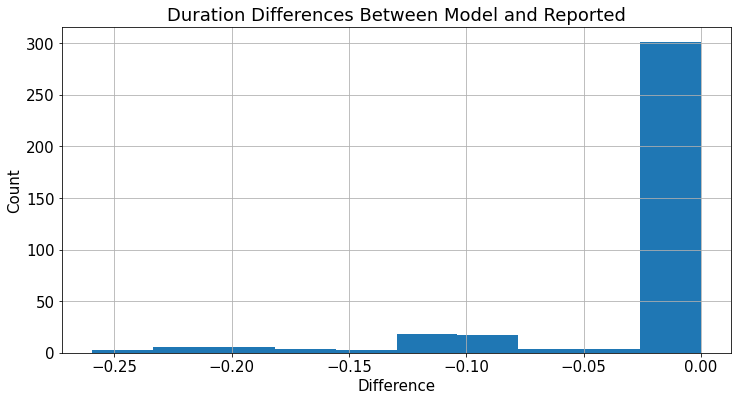

In [19]:
duration = pd.DataFrame({'analytic':model_duration,'quoted':metrics['duration'][CF.index]},index=CF.index)
duration['diff'] = duration['analytic'] - duration['quoted']

duration['diff'].hist()
plt.title('Duration Differences Between Model and Reported')
plt.xlabel('Difference')
plt.ylabel('Count')
plt.show()

## Estimate Sensitivity Directly

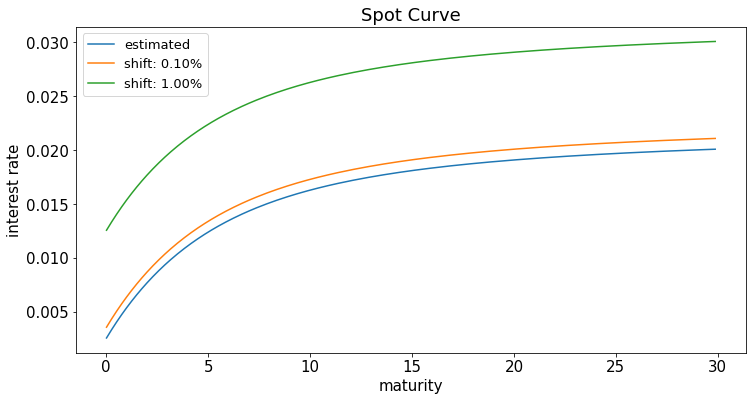

In [20]:
dr_list = [.0010, .0100]
for dr in dr_list:
    curves[f'shift: {dr:.2%}'] = curves['estimated'] + dr

curves.plot(xlabel='maturity',ylabel='interest rate',title='Spot Curve')
plt.show()

In [21]:
discount = pd.DataFrame(index=CF.columns,dtype=float)
for col in curves:
    discount[col] = intrate_to_discount(curves[col].values,curves.index.values)

prices_shifted = CF @ discount

sensitivity = duration[['analytic']].copy()
for dr in dr_list:
    col = f'shift: {dr:.2%}'
    sensitivity[col] = (1/prices_shifted['estimated']) * (prices_shifted['estimated'] - prices_shifted[col]) / dr

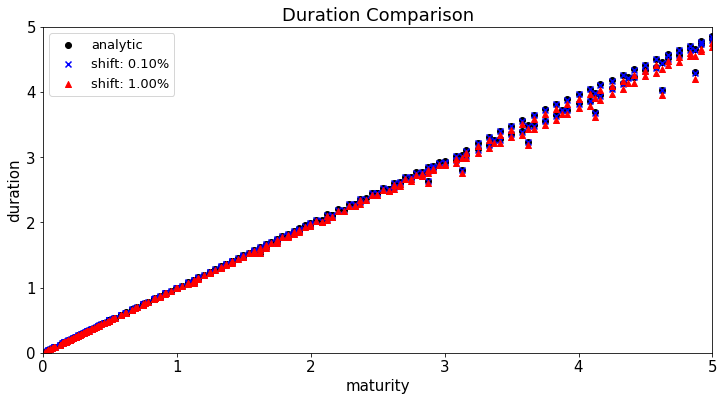

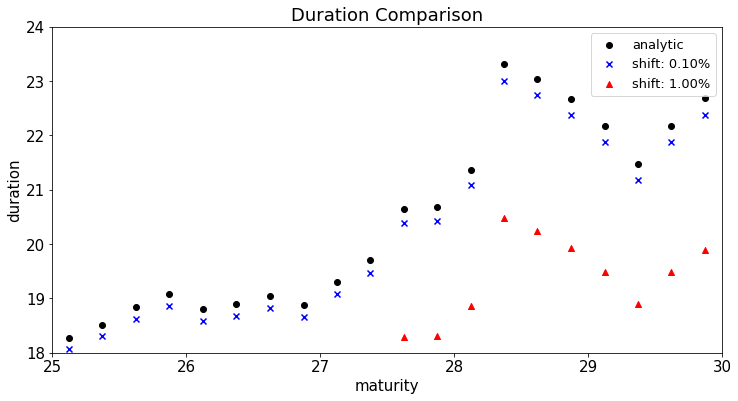

In [22]:
maturity_index = get_maturity_delta(metrics['maturity date'][sensitivity.index],t_current=t_current)

marker_list = ['o', 'x', '^', 'v','+']
color_list = ['k', 'b', 'r', 'g', 'm']

plt.figure()
ax = plt.gca()

for i, col in enumerate(sensitivity.columns):
    ax.scatter(x=maturity_index, y=sensitivity[col], marker=marker_list[i], color=color_list[i])

plt.xlabel('maturity')
plt.ylabel('duration')
plt.legend(sensitivity.columns)
plt.title(f'Duration Comparison')
plt.xlim(0,5)
plt.ylim(0,5)
plt.show()    



plt.figure()
ax = plt.gca()

for i, col in enumerate(sensitivity.columns):
    ax.scatter(x=maturity_index, y=sensitivity[col], marker=marker_list[i], color=color_list[i])

plt.xlabel('maturity')
plt.ylabel('duration')
plt.legend(sensitivity.columns)
plt.title(f'Duration Comparison')
plt.xlim(25,30)
plt.ylim(18,24)
plt.show()    

### Errors between analytic and numeric duration

The following table shows the errors of the numerical derivatives against the quoted duration.

In [23]:
sensitivity.sub(sensitivity['analytic'],axis=0).describe().drop(index=['count'],columns=['analytic']).style.format('{:.2%}')

,shift: 0.10%,shift: 1.00%
mean,-3.56%,-33.59%
std,7.00%,65.15%
min,-30.58%,-282.25%
25%,-1.89%,-18.50%
50%,-0.41%,-4.05%
75%,-0.05%,-0.46%
max,-0.00%,-0.00%


## Analytic or numeric?

Is duration a historic relic?
* In a world of abundant computing, why use this formula rather than the numeric derivative?
* In some circumstances, it would be unwieldly to constantly compute the numeric derivative of a large portfolio, at high frequency.
* That said, the concept of duration is more important than the particular analytic formula.

#### For small shifts in the yield curve, duration gives a close approximation.

#### For large shifts in the spot curve, we need something better.

### Trying the approximation

The table below shows the pricing errors from pricing a 100bps (1%) shift up in all rates, as compared to the delta approximation and delta & convexity approximation.

In [24]:
prices_approx_duration = pd.DataFrame(dtype=float,index=prices_shifted.index)

p = prices_shifted['estimated']

for dr in dr_list:    
    dp_duration = p * (-duration['analytic'] * dr)

    col = f'shift: {dr:.2%}'
    prices_approx_duration[col] = p + dp_duration

error_duration = (prices_shifted - prices_approx_duration).drop(columns=['estimated'])
error_duration.describe().drop(index=['count']).style.format('{:.2%}')

,shift: 0.10%,shift: 1.00%
mean,0.41%,38.35%
std,0.79%,73.72%
min,0.00%,0.00%
25%,0.00%,0.47%
50%,0.04%,4.19%
75%,0.20%,19.34%
max,3.04%,280.40%


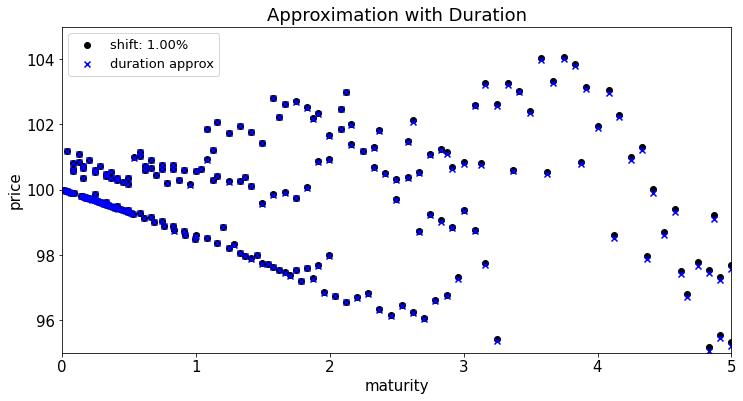

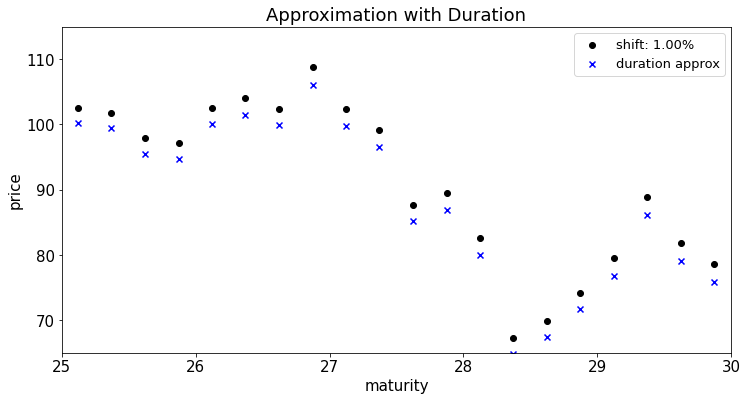

In [25]:
col = prices_shifted.columns[-1]

temp = prices_shifted[[col]].copy()
temp['duration approx'] = prices_approx_duration[[col]]

plt.figure()
ax = plt.gca()

for i, col in enumerate(temp.columns):
    ax.scatter(x=maturity_index, y=temp[col], marker=marker_list[i], color=color_list[i])

plt.xlabel('maturity')
plt.ylabel('price')
plt.legend(temp.columns)
plt.title(f'Approximation with Duration')
plt.xlim(0,5)
plt.ylim(95,105)
plt.show()    

########

plt.figure()
ax = plt.gca()

for i, col in enumerate(temp.columns):
    ax.scatter(x=maturity_index, y=temp[col], marker=marker_list[i], color=color_list[i])

plt.xlabel('maturity')
plt.ylabel('price')
plt.legend(temp.columns)
plt.title(f'Approximation with Duration')
plt.xlim(25,30)
plt.ylim(65,115)
plt.show()    

In [26]:
def price_bond(dr,KYTREASNO):
    
    p = prices_shifted.loc[KYTREASNO,'estimated']
    
    dp_duration = p * (-duration.loc[KYTREASNO,'analytic'] * dr)
    dp_convexity = dp_duration + p * .5 * (CF_wts.loc[KYTREASNO,:] * CF_intervals**2).sum() * dr**2
    
    prices = pd.Series(index=['estimated','duration','convexity'],dtype=float)
    prices.loc['duration'] = p + dp_duration
    prices.loc['convexity'] = p + dp_convexity
    
    disc = pd.Series(intrate_to_discount(curves['estimated'].values+dr,curves.index.values))
    disc.index = CF.columns
    prices.loc['estimated'] = CF.loc[KYTREASNO,:] @ disc

    return prices

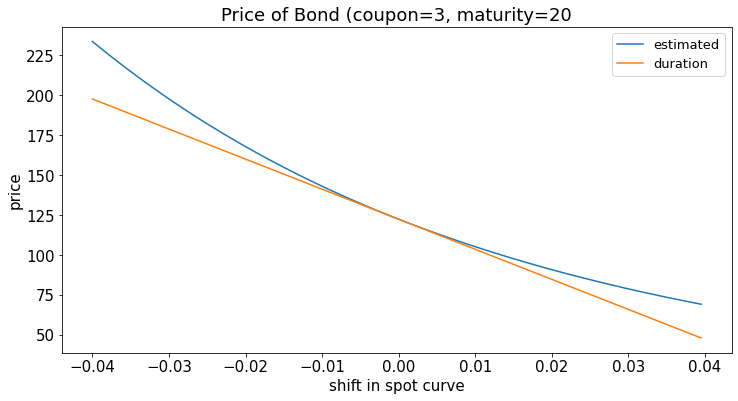

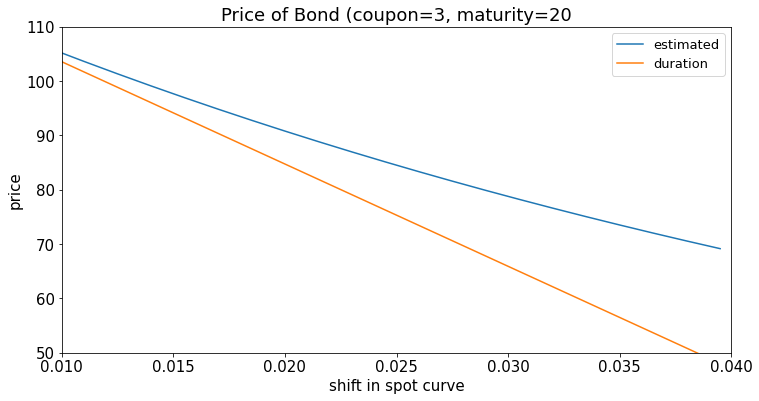

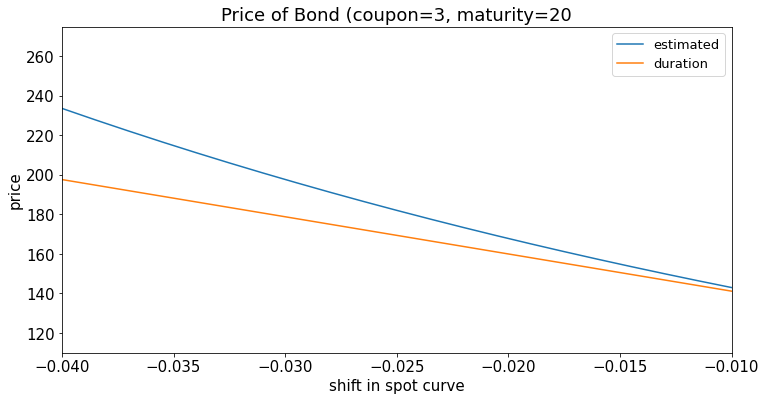

In [27]:
drgrid = np.arange(-.04,.04,.0005)
KYTREASNO = 206341

temp = pd.DataFrame(index=drgrid,dtype=float,columns=['estimated','duration','convexity'])
for dr in drgrid:
    temp.loc[dr,:] = price_bond(dr,KYTREASNO)

mat = metrics.loc[KYTREASNO,'maturity interval']
coup = metrics.loc[KYTREASNO,'coupon rate']

plottitle = f'Price of Bond (coupon={coup:.0f}, maturity={mat:.0f}'
temp[['estimated','duration']].plot(ylabel='price',xlabel='shift in spot curve',title=plottitle)
plt.show()

temp[['estimated','duration']].plot(ylabel='price',xlabel='shift in spot curve',title=plottitle,xlim=(.01,.04),ylim=(50,110))
plt.show()

temp[['estimated','duration']].plot(ylabel='price',xlabel='shift in spot curve',title=plottitle,xlim=(-.04,-.01),ylim=(110,275))
plt.show()

## Other Durations

### Dollar Duration

This version simply reports the change in dollar terms rather than percentage of price terms:

$\begin{align}
\text{dollar duration} = D_{\$} \equiv -\frac{dP}{dr}
\end{align}$

### Macauley Duration

The definition of duration above is a response to a parallel shift in the **spot curve**. This is sometimes known as **Macauley Duration**.

### Modified Duration

Modified duration considers a move in the bond's YTM instead of a shift in the entire **spot curve**.

It requires a small modification to the duration formula above, at least for standard coupon bonds:

$\begin{align}
\text{modified duration} \equiv D_{\text{ytm}} \equiv &  \quad \frac{1}{1+y/2} D \\
=&  -\frac{1}{1+y/2}\frac{1}{P}\frac{dP}{dr}
\end{align}$

#### Modified duration is less useful.

It is a sensitivity to a change in the YTM, but YTM is specific to a particular instrument, so a shift in this ``curve'' is not well specified.

Furthermore, for more complicated instruments, the YTM will not be defined, and thus Modified duration is not well defined. However, our definition of duration is defined, notwithstanding the complexity of the instrument.

# Convexity

Duration approximates the bond's price change with a linear approximation, (the first derivative.)

This approximation is good for small changes in the rate, but it is inadequate for larger changes.

Accordingly, we may find a second-order approximation beneficial.

This second-order term is known as the **convexity** of the bond.

## Price approximation

$\begin{align}
\frac{dP}{P} \approx -D\times dr + \frac{1}{2}C\times (dr)^2
\end{align}$

where $C$ denotes the convexity of the bond,

$\begin{align}
C \equiv & \frac{1}{P}\frac{d^2P}{dr^2}
\end{align}$


## Zero coupon bond

For a zero-coupon bond, one can show that the convexity is

$\begin{align}
C =& \frac{1}{P(t,T,0)}\frac{d^2P(t,T,0)}{dr^2}\\
=& (T-t)^2
\end{align}$


## Coupon bonds

Again, we rely on the result that a coupon bond may be decomposed as a portfolio of zero-coupon bonds (STRIPS).

For a portfolio with weights $w_i$ in securities each with convexity, $C_i$, we have,

$\begin{align}
C = \sum_{i=1}^n w_iC_i
\end{align}$

Then for a coupon bond with cashflows at times $T_i$, we once again decompose it as follows,

$\begin{align}
C =& \sum_{i=1}^n w_i(T_i-t)^2\\
w_i \equiv& \frac{c}{2}\frac{P(t,T_i,0)}{P(t,T,c)}\text{ for }1\le i < n\\
w_n \equiv& \left(1+\frac{c}{2}\right)\frac{P(t,T,0)}{P(t,T,c)}
\end{align}$

where these are the same weights used for the coupon bond duration calculation.

### Trying the approximation

The table below shows the pricing errors from pricing a 100bps (1%) shift up in all rates, as compared to the delta approximation and delta & convexity approximation.

In [28]:
prices_approx_convexity = pd.DataFrame(dtype=float,index=prices_shifted.index)

p = prices_shifted['estimated']

for dr in dr_list:    
    dp_duration = p * (-duration['analytic'] * dr)
    dp_convexity = dp_duration + p * .5 * (CF_wts * CF_intervals**2).sum(axis=1) * dr**2

    col = f'shift: {dr:.2%}'
    prices_approx_convexity[col] = p + dp_convexity

error_convexity = (prices_shifted - prices_approx_convexity).drop(columns=['estimated'])
errors_approx = pd.concat([error_duration, error_convexity],axis=1,keys=['duration','convexity'])
errors_approx.describe().drop(index=['count']).style.format('{:.2%}')

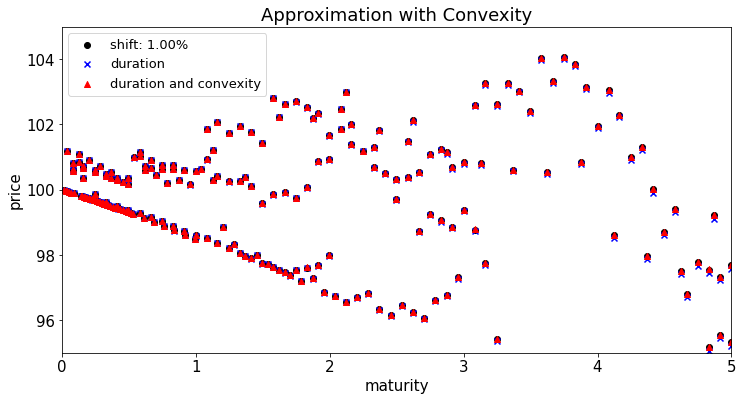

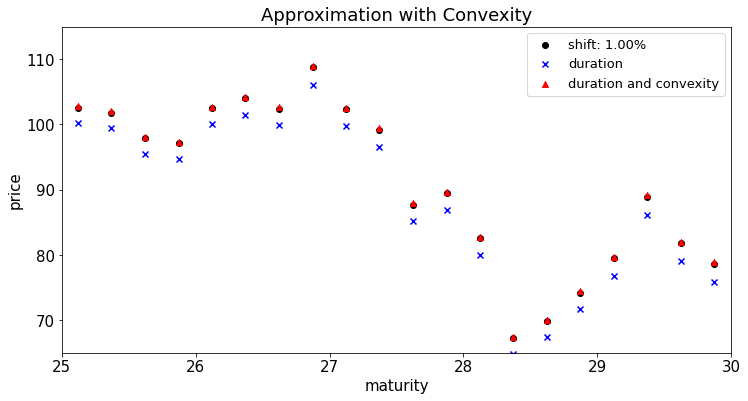

In [29]:
col = prices_shifted.columns[-1]
temp = prices_shifted[[col]].copy()
temp['duration'] = prices_approx_duration[[col]]
temp['duration and convexity'] = prices_approx_convexity[[col]]

plt.figure()
ax = plt.gca()

for i, col in enumerate(temp.columns):
    ax.scatter(x=maturity_index, y=temp[col], marker=marker_list[i], color=color_list[i])

plt.xlabel('maturity')
plt.ylabel('price')
plt.legend(temp.columns)
plt.title(f'Approximation with Convexity')
plt.xlim(0,5)
plt.ylim(95,105)
plt.show()    

########

plt.figure()
ax = plt.gca()

for i, col in enumerate(temp.columns):
    ax.scatter(x=maturity_index, y=temp[col], marker=marker_list[i], color=color_list[i])

plt.xlabel('maturity')
plt.ylabel('price')
plt.legend(temp.columns)
plt.title(f'Approximation with Convexity')
plt.xlim(25,30)
plt.ylim(65,115)
plt.show()    

## Positive convexity and returns

In the charts above, note that the duration approximation always underestimates the actual price.

This is not a fluke of this data; rather, it is a general property.

Furthermore, note that convexity as given in the definitions above is always positive.

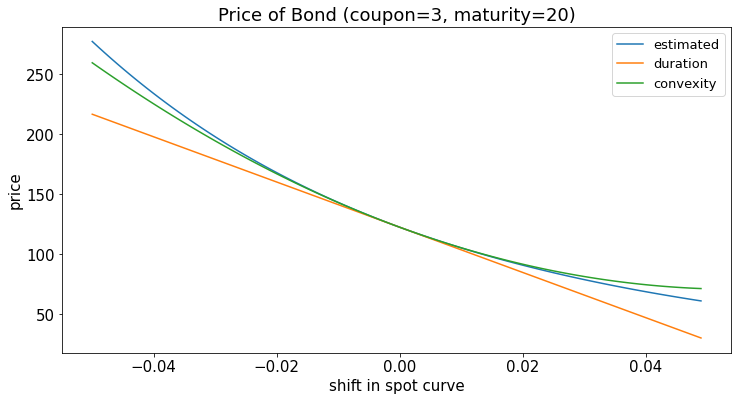

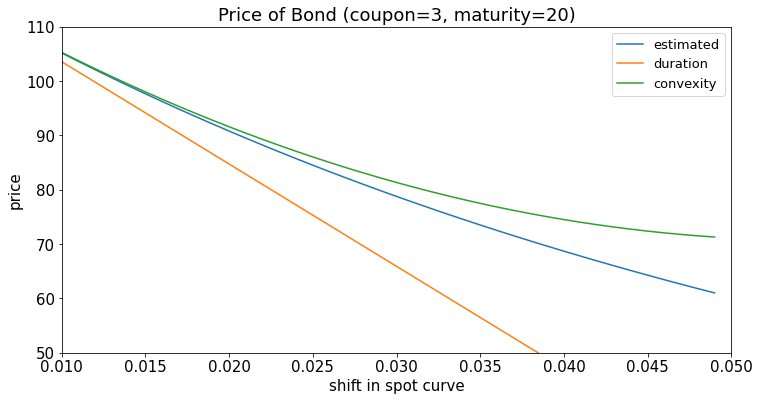

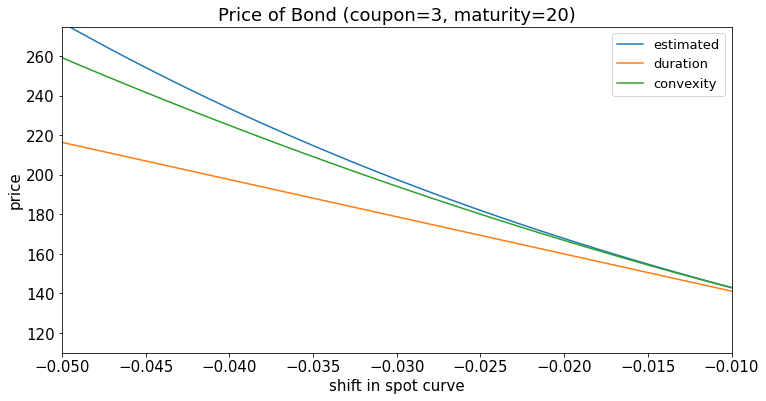

In [30]:
drgrid = np.arange(-.05,.05,.001)
KYTREASNO = 206341

temp = pd.DataFrame(index=drgrid,dtype=float,columns=['estimated','duration','convexity'])
for dr in drgrid:
    temp.loc[dr,:] = price_bond(dr,KYTREASNO)

mat = metrics.loc[KYTREASNO,'maturity interval']
coup = metrics.loc[KYTREASNO,'coupon rate']

plottitle = f'Price of Bond (coupon={coup:.0f}, maturity={mat:.0f})'
temp.plot(ylabel='price',xlabel='shift in spot curve',title=plottitle)
plt.show()

temp.plot(ylabel='price',xlabel='shift in spot curve',title=plottitle,xlim=(.01,.05),ylim=(50,110))
plt.show()

temp.plot(ylabel='price',xlabel='shift in spot curve',title=plottitle,xlim=(-.05,-.01),ylim=(110,275))
plt.show()

# Beyond Parallel Shifts

Potentially, the entire spot curve matters for pricing.

We may want to check sensitivity to other aspects of the curve, not just parallel shifts.



## Shapes of the yield curve

We are interested in sensitivity to the spot curve, but it is closely related to the yield curve.

As is widely done, we will focus on shapes of the yield curve, to avoid needing to repeatedly estimate a spot curve and deal with potential questions around that methodology.

The **yield curve** changes beyond just parallel shifts.

Many of these changes and shapes can be described in terms of the curve's
* level
* slope
* curvature

The figure below shows how these shapes have looked very different across time.

We define 
* level = long-term yield, (often 10 year or 30 year) minus short-term yield (often 1 year or 2 year)
* curvature = Mid-range yield (often 5 year or 10 year) minus short-term yield and minus long-term yield

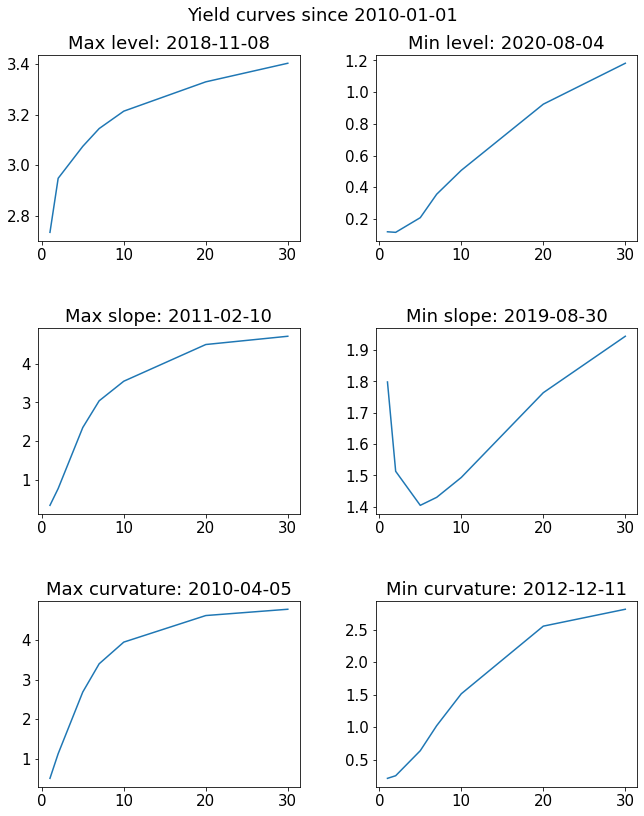

In [31]:
shapes_all = pd.DataFrame(yields.mean(axis=1),columns=['level'])
shapes_all['slope'] = yields[30]-yields[1]
shapes_all['curvature'] = -yields[1] + 2 * yields[10] - yields[30]

DATETHRESH = '2010-01-01'
shapes = shapes_all[shapes_all.index>DATETHRESH]

fig, axs = plt.subplots(3,2,figsize=(10,12))

idx = shapes['level'].idxmax()
lab = f'Max level: {yields.loc[idx].name:%Y-%m-%d}'
yields.loc[idx,:].plot(ax=axs[0,0],title = lab)

idx = shapes['level'].idxmin()
lab = f'Min level: {yields.loc[idx].name:%Y-%m-%d}'
yields.loc[idx,:].plot(ax=axs[0,1],title = lab)

idx = shapes['slope'].idxmax()
lab = f'Max slope: {yields.loc[idx].name:%Y-%m-%d}'
yields.loc[idx,:].plot(ax=axs[1,0],title = lab)

idx = shapes['slope'].idxmin()
lab = f'Min slope: {yields.loc[idx].name:%Y-%m-%d}'
yields.loc[idx,:].plot(ax=axs[1,1],title = lab)

idx = shapes['curvature'].idxmax()
lab = f'Max curvature: {yields.loc[idx].name:%Y-%m-%d}'
yields.loc[idx,:].plot(ax=axs[2,0],title = lab)

idx = shapes['curvature'].abs().idxmin()
lab = f'Min curvature: {yields.loc[idx].name:%Y-%m-%d}'
yields.loc[idx,:].plot(ax=axs[2,1],title = lab)

fig.tight_layout(pad=3.0)
fig.suptitle(f'Yield curves since {DATETHRESH}')
#plt.legend(labs)
plt.show()

## PCA

Principal Component Analysis (PCA) may be helpful in describing these shapes.

PCA gives linear combinations of interest rates along the curve which have maximum explanatory power in its variation.

The yield curve data we're using is specified at **7 maturities, so we have 7 time series.**

In [32]:
yields.tail()

,1,2,5,7,10,20,30
caldt,,,,,,,
2022-03-25,1.572140,2.263497,2.518140,2.542305,2.461314,2.708210,2.582279
2022-03-28,1.626348,2.296073,2.550019,2.538519,2.462174,2.685246,2.537997
2022-03-29,1.631957,2.349644,2.500285,2.472474,2.398616,2.641262,2.498180
2022-03-30,1.616406,2.283531,2.438473,2.420647,2.356208,2.610034,2.472816
2022-03-31,1.701437,2.329352,2.451945,2.421906,2.325506,2.583969,2.433047


PCA analysis will return 7 linear combinations of these yields.

The factors are orthogonal to each other.

They explain decreasing amounts of variance.
* Given the high correlation across these rates, PCA can explain most the total variation with a single factor.

#### The table below shows that the first factor (and certainly the first 3) explain most variation.

In [33]:
pca = PCA(svd_solver='full')
pca.fit(yields)
pca_var_explained = pd.DataFrame(pca.explained_variance_ratio_,columns=['Variance explained']).T
pca_var_explained.columns = list(np.arange(1,8,1))
pca_var_explained.style.format('{:.2%}'.format)

,1,2,3,4,5,6,7
Variance explained,97.25%,2.36%,0.28%,0.04%,0.04%,0.02%,0.01%


### Level, slope, and curvature

If we examine the loadings of the PCs on the respective yields, we find that the first three PCs are interpretable as 
* level
* slope
* curvature

Note that this is not a structured result, but rather an empirical regularity of dealing with interest rate data.

It says that the three factors above explain most interest rate variation.

While we could continue to define these factors ad hoc, the PCA estimation of them gives us a more systematic approach.

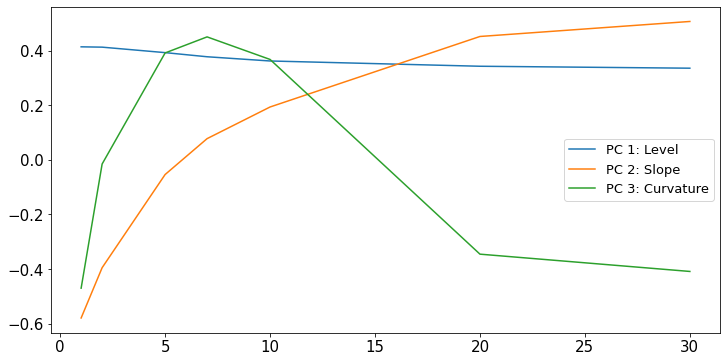

In [34]:
pca_wts = pd.DataFrame(pca.components_,columns=yields.columns)
pca_wts.index = ['PC 1: Level','PC 2: Slope','PC 3: Curvature','PCA 4','PCA 5','PCA 6','PCA 7']
if pca_wts.loc['PC 3: Curvature',10]<0:
    pca_wts.loc['PC 3: Curvature'] *= -1
pca_wts.T.iloc[:,0:3].plot();

## Factor Duration

Instead of analyzing the sensitivity of price to a parallel shift in rates, we could analyze a change to the principal components of the curve.

### Zero coupon bond
Consider a zero-coupon bond with maturity $T_i$. Then,

$\begin{align}
D_{\text{pca}} \equiv&  -\frac{1}{P(t,T_i,0)}\frac{dP(t,T_i,0)}{dz}\\
=& -\frac{1}{P}\frac{dP(t,T_i,0)}{dr_i}\frac{dr_i}{dz}\\
=& (T_i-t)\frac{dr_i}{dz}\\
=& (T_i-t)\phi_{i}
\end{align}$

where $\phi_i$ is the loading (beta) of $r_i$ on $z$.


### Coupon bond

Suppose a coupon bond pays coupons at $n$ dates, denoted $T_i$ for $1\le i\le n$.

Then, we modify the earlier duration formula for a coupon bond, again decomposing it as a portfolio of zero-coupon STRIPS.

$\begin{align}
D_{\text{z}} \equiv&  -\frac{1}{P(t,T,c)}\frac{dP(t,T,c)}{dz}\\
=& \sum_{i=1}^n w_i (T_i-t) \phi_i
\end{align}$

### Price approximation

Suppose we want to approximate the percentage price change across several factors, $z_1, z_2, \ldots$. Then we can use the approximation,

$\begin{align}
\frac{dP}{P} \approx -D_{z_1}\times dz_1 -D_{z_2}\times dz_2 -D_{z_3}\times dz_3
\end{align}$

### This approach would work for any chosen factor, $z$. But it is especially useful for PCA.
* The PCs are orthogonal, meaning it is interpretable to consider a shock to $z_1$ holding everything else constant. If we choose correlated factors, it is harder to interpret a change in $z_1$ holding $z_2$ constant.
* By construction, the PCs explain a large amount of rate variation.
* The PCs happen to lead to interpretable factors: level, slope, and curvature.
* Finally, with principal components, there is no extra step to estimating the loadings, $\phi_i$, as they are calculated in determining the PCs. (No need to run extra regressions.)

See the PCA loadings, $\phi_{j,i}$ below.

In [35]:
pca_wts

,1,2,5,7,10,20,30
PC 1: Level,0.414006,0.412798,0.392748,0.377606,0.362126,0.342820,0.335705
PC 2: Slope,-0.579680,-0.395445,-0.054039,0.077522,0.193496,0.451925,0.506939
PC 3: Curvature,-0.470428,-0.015420,0.391563,0.450435,0.367739,-0.345818,-0.409175
PCA 4,0.346599,-0.375237,-0.370755,-0.115613,0.740590,-0.001670,-0.199408
PCA 5,-0.039405,0.010488,0.046625,0.003911,-0.125681,0.746711,-0.650211
PCA 6,0.344939,-0.575527,-0.026141,0.645215,-0.363152,-0.029103,0.008591
PCA 7,0.174929,-0.448150,0.741074,-0.467792,-0.006500,-0.014852,0.016697


For more on factor duration, see the application at the end.

# Application: Hedging Duration and Convexity

# Application: Factor Duration Hedging

Try using specified factors:
* Level: average of all yields at a given point in time
* Slope: 30-year minus 10-year yield
* Curvature: 10-year minus 1-year minus 30-year

Build the factors

In [36]:
shapes

,level,slope,curvature
caldt,,,
2010-01-04,2.896829,4.129791,2.539552
2010-01-05,2.849496,4.126881,2.493824
2010-01-06,2.884791,4.219587,2.544432
2010-01-07,2.893096,4.193588,2.525261
2010-01-08,2.887523,4.260494,2.536965
...,...,...,...
2022-03-25,2.378269,1.010139,0.768208
2022-03-28,2.385197,0.911650,0.760003
2022-03-29,2.356060,0.866223,0.667095


### Get the factor loadings

In [37]:
phi = pd.DataFrame(index=shapes.columns,columns=yields.columns,dtype=float).T

for col in yields.columns:
    phi.loc[col,:] = LinearRegression(fit_intercept=False).fit(shapes_all,yields[col]).coef_

phi

,level,slope,curvature
1,0.995636,-0.449339,-0.235365
2,0.998768,-0.390793,-0.041125
5,1.005271,-0.169041,0.170784
7,1.004174,-0.049128,0.219583
10,0.995636,0.050661,0.264635
20,1.004879,0.456979,-0.143146
30,0.995636,0.550661,-0.235365


### Result is similar to PCA

This demonstrates that PCA is extracting what we think of as level, slope, and curvature.

Note the high correlations on the diagonal of the matrix below, which is comparing
* PCA constructed shocks
* Ad-hoc shape shocks

In [38]:
pca_factors = yields @ pca_wts.T
pd.concat([shapes_all, pca_factors.iloc[:,0:3]], axis=1, keys=['shapes', 'pca']).corr().loc['shapes', 'pca']

,PC 1: Level,PC 2: Slope,PC 3: Curvature
level,0.999929,0.011859,-0.000634
slope,-0.417780,0.903683,0.017587
curvature,-0.212055,0.596871,0.723934


### Calculate the factor duration for each treasury issue

1. How similar are the PCA durations to the ad-hoc shape durations?
2. How similar is the PCA level duration to the analytic duration (shift in $r$?)
3. How would the estimation and application change if we had PCA of the spot curve instead of the yield curve?